In [1]:
# Deep Learning with Python Ch6: IMDb example
# load and organize raw data
import os

# location of the raw training data
imdb_dir  = 'C:\\Users\\Carol\\Desktop\\aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

# organize data 
labels = []
texts  = []
for label_type  in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    
    for fname in os.listdir(dir_name):
        # each entry of texts is a review in string format
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            
            # each entry of labels records the sentiment of each review
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [2]:
# tokenize text data
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_len       = 100    # only look at 1st 100 words of each review
train_samples = 200    # only train on 200 reviews
val_samples   = 10000  # validate on 10,000 samples
max_words     = 10000  # only consider top 10,000 most common words

# build word index
# 1st, create a tokenizer that only considers max_words # most common words
tokenizer = Tokenizer(num_words=max_words) 
# then build the word index based on our text data
tokenizer.fit_on_texts(texts)

# turn strings into lists of integer indices based on the built word index
sequences = tokenizer.texts_to_sequences(texts)

# do a check
word_index = tokenizer.word_index
print('%s unique tokens are found' %len(word_index))

# pad shorter sequences with zeros to achieve maxlen # of words
data   = pad_sequences(sequences, maxlen=max_len)
labels = np.array(labels)
# check if the shape of texts and labels are consistent
print('shape of data tensor:', data.shape)
print('shape of label tensor:', labels.shape)

# shuffle data cuz raw data was ordered
indices = np.arange(data.shape[0])
np.random.seed(1234)
np.random.shuffle(indices)
data   = data[indices]
labels = labels[indices]

# split training data into train and validation
x_train = data[:train_samples]
y_train = labels[:train_samples]
x_val   = data[train_samples : train_samples+val_samples]
y_val   = labels[train_samples : train_samples+val_samples]


Using TensorFlow backend.


88582 unique tokens are found
shape of data tensor: (25000, 100)
shape of label tensor: (25000,)


In [3]:
# parse the GloVe word-embeddings file
# location of the file
glove_dir = 'C:\\Users\\Carol\\Desktop\\glove.6B'

# create a dict with unique word as the key and its indices as value
glove_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word   = values[0] # unique word
    coefs  = np.asarray(values[1:], dtype='float32') # indices of the unique word
    glove_index[word] = coefs
f.close()

print('%s word vectors found' %len(glove_index))

400000 word vectors found


In [4]:
# create GloVe word-embeddings matrix based on our text data
embedding_dim = 100 # dimension of coefs

glove_matrix = np.zeros((max_words, embedding_dim)) # default is zero

# replace 0 with 1 if the word is found in the index
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = glove_index.get(word)
        if embedding_vector is not None:
            glove_matrix[i] = embedding_vector

In [11]:
# Approach 1: train network using pretrained word embeddings
# build network
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [12]:
# load pretrained word embeddings
model.layers[0].set_weights([glove_matrix])
model.layers[0].trainable = False

# compile and fit network
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, 
                    validation_data=(x_val, y_val), verbose=0)

# save network
model.save_weights('pretrained_glove_model.h5')

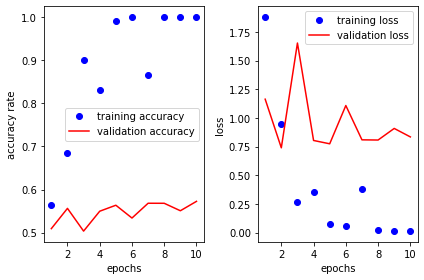

In [13]:
# plot loss and accuracy
%matplotlib inline
import matplotlib.pyplot as plt

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc)+1)

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='training accuracy')
plt.plot(epochs, val_acc, 'r', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy rate')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

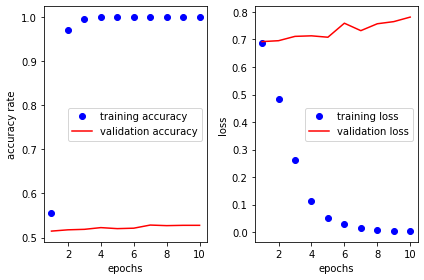

In [14]:
# Approach 2: train network without pretrained word embeddings
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

# start with a fresh network
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# train network
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, 
                    validation_data=(x_val, y_val), verbose=0)

# plot loss and accuracy
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc)+1)

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='training accuracy')
plt.plot(epochs, val_acc, 'r', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy rate')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# pretrained model performs better, so use pretrained model on test data
# tokenize test data
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts  = []
for label_type  in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    
    for fname in os.listdir(dir_name):
        # each entry of texts is a review in string format
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            
            # each entry of labels records the sentiment of each review
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test    = pad_sequences(sequences, maxlen=max_len)
y_test    = np.asarray(labels)

# use network on test data
model.load_weights('pretrained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 55us/step


[0.8535108809280395, 0.56192]

In [1]:
# use RNN on IMDb data
# load and preprocess IMDb data
import numpy as np
from keras.datasets import imdb
from keras.preprocessing import sequence

# # of most common words to consider
max_features = 10000 
# only consider 1st 500 words of each review 
# within the defined most common words
max_len      = 500 
# batch size
batch_size   = 32

# save np.load
np_load_old = np.load

# modify the default parameters of np.load: set allow_pickle to true
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)

print('load data')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

# restore np.load for future normal usage
np.load = np_load_old

print('pad sequences')
input_train = sequence.pad_sequences(input_train, maxlen=max_len)
input_test  = sequence.pad_sequences(input_test, maxlen=max_len)

print('input_train shape', input_train.shape)
print('input_est shape', input_test.shape)

Using TensorFlow backend.


load data
25000 train sequences
25000 test sequences
pad sequences
input_train shape (25000, 500)
input_est shape (25000, 500)


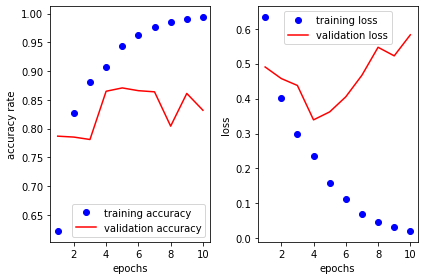

In [23]:
# Approach 3: train network using simple RNN
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN

# build network
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

# train network
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, 
                    validation_split=0.2, verbose=0)

# plot loss and accuracy
%matplotlib inline
import matplotlib.pyplot as plt

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc)+1)

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='training accuracy')
plt.plot(epochs, val_acc, 'r', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy rate')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

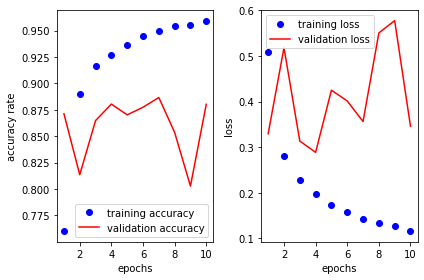

In [24]:
# Approach 4: train network using LSTM
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

# build network
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

# train network
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, 
                    validation_split=0.2, verbose=0)

# plot loss and accuracy
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc)+1)

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='training accuracy')
plt.plot(epochs, val_acc, 'r', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy rate')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

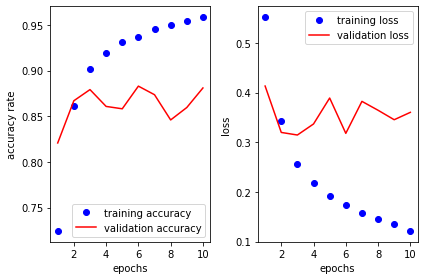

In [4]:
# Approach 5: train network using bidirectional LSTM
from keras.models import Sequential
from keras.layers import Bidirectional, Dense, Embedding, LSTM

# build model 
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

# train network
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, 
                    validation_split=0.2, verbose=0)

# plot loss and accuracy
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc)+1)

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='training accuracy')
plt.plot(epochs, val_acc, 'r', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy rate')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

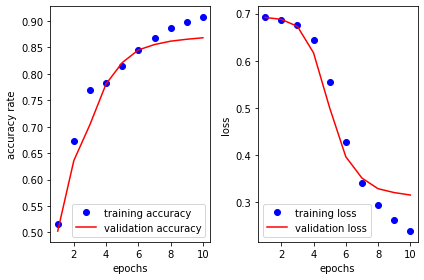

In [3]:
# Approach 6: train network using 1D convnet
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Embedding, GlobalMaxPooling1D, MaxPooling1D
from keras.optimizers import RMSprop

# build model 
model = Sequential()
model.add(Embedding(max_features, 128, input_length=max_len))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

# train network
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, 
                    validation_split=0.2, verbose=0)

# plot loss and accuracy
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc)+1)

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='training accuracy')
plt.plot(epochs, val_acc, 'r', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy rate')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()